In [39]:
import pandas as pd
data_path = r"data\trials.csv"
df = pd.read_csv(data_path)
df.head()

,nctid,description,label
0,NCT02464748,MND is often referred to as amyotrophic latera...,ALS
1,NCT00362362,OBJECTIVE:||The causes of sporadic motor neuro...,ALS
2,NCT03154450,Non-invasive ventilation (NIV) use in patients...,ALS
3,NCT03487263,The objectives of this study are to determine:...,ALS
4,NCT04454892,"With the development of supportive measures, t...",ALS


In [40]:
X= df['description']
y = df['label']

print(f"Length of X: {len(X)}")
print(f"Length of y: {len(y)}")

Length of X: 1759
Length of y: 1759


In [ ]:
#Data Preprocessing
import string

def data_preprocessing(df):
    
    #convert to lowercase
    df['description'] = df['description'].str.lower()
    #remove punctuation
    df['description'] = df['description'].str.translate(str.maketrans('','',string.punctuation)) 

    #REmove stopwords
    from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
    df['description'] = df['description'].apply(lambda x: ' '.join([word for word in x.split() if word not in ENGLISH_STOP_WORDS])) #remove punctuation


    #Tokenization
    import nltk
    from nltk.tokenize import word_tokenize
    df['description'] =df['description'].apply(word_tokenize) #List of words

    #Lemmatization
    from nltk.stem import WordNetLemmatizer
    lemmatizer = WordNetLemmatizer()
    df['description'] = df['description'].apply(lambda x: ' '. join(lemmatizer.lemmatize(word) for word in x))

    #Label Encoding
    from sklearn.preprocessing import LabelEncoder
    label_encoder = LabelEncoder()
    df['label'] = label_encoder.fit_transform(df['label'])
    
    return df

In [ ]:
print(df['label'].head()) #Labels are encoded

0    0
1    0
2    0
3    0
4    0
Name: label, dtype: int64


In [36]:
df.isnull().sum() #checking for null values

nctid          0
description    0
label          0
dtype: int64

In [42]:
#split to train and temperary set for test and validation split
from sklearn.model_selection import train_test_split

main_df, inference_df = train_test_split(df, test_size=0.1, stratify=df['label'], random_state=42)

train_df, temp_df = train_test_split(main_df, test_size=0.2, stratify=main_df['label'], random_state=42)

#split temp_df into test_df and val_df
val_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df['label'], random_state=42)

#check the distribution of labels in each set
print(f"Training set size: {len(train_df)}")
print("Train_df distribution", train_df['label'].value_counts(normalize=True))
print(f"\nValidation set size: {len(val_df)}")
print("Validation_df distribution", val_df['label'].value_counts(normalize=True))
print(f"\nTest set size: {len(test_df)}")
print("Test_df distribution", test_df['label'].value_counts(normalize=True))

Training set size: 1266
Train_df distribution label
0    0.209321
1    0.209321
2    0.203002
4    0.190363
3    0.187994
Name: proportion, dtype: float64

Validation set size: 158
Validation_df distribution label
1    0.208861
0    0.208861
2    0.202532
3    0.189873
4    0.189873
Name: proportion, dtype: float64

Test set size: 159
Test_df distribution label
2    0.207547
1    0.207547
0    0.207547
4    0.194969
3    0.182390
Name: proportion, dtype: float64


In [43]:
print(main_df.shape)
print(inference_df.shape)

(1583, 3)
(176, 3)


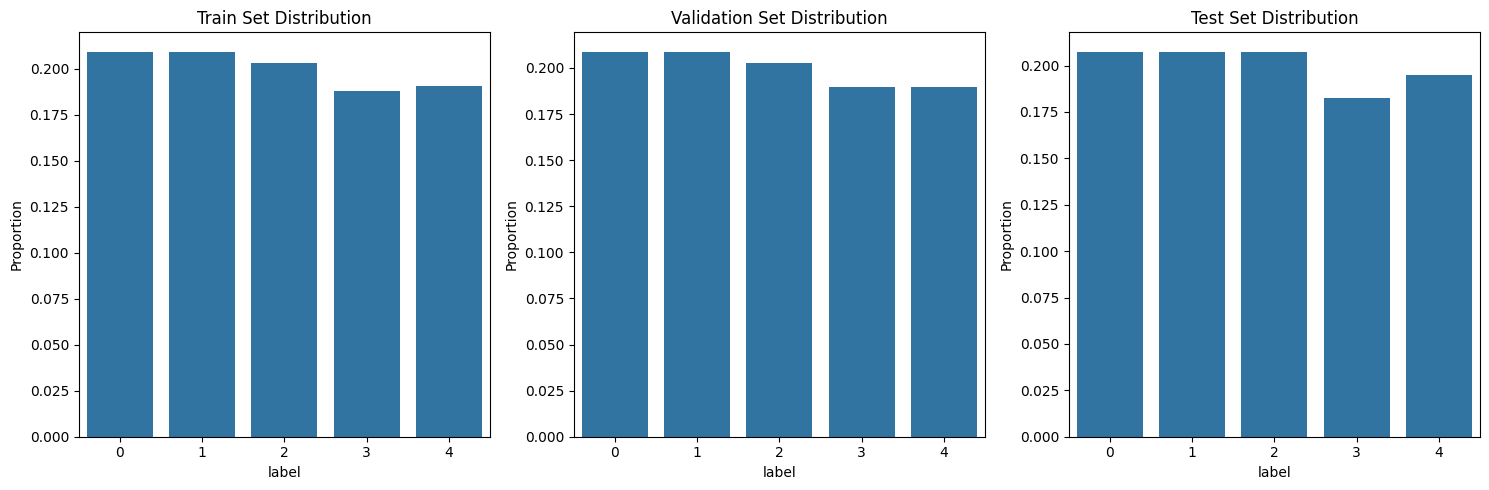

In [45]:
import matplotlib.pyplot as plt
import seaborn as sns

# Function to plot label distribution
def plot_label_distribution(train_df, val_df, test_df):
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    # Training Set
    sns.barplot(x=train_df["label"].value_counts(normalize=True).index, 
                y=train_df["label"].value_counts(normalize=True).values, ax=axes[0])
    axes[0].set_title("Train Set Distribution")
    axes[0].set_ylabel("Proportion")
    # axes[0].tick_params(axis='x', labelrotation=45)  # Rotate x-axis labels

    # Validation Set
    sns.barplot(x=val_df["label"].value_counts(normalize=True).index, 
                y=val_df["label"].value_counts(normalize=True).values, ax=axes[1])
    axes[1].set_title("Validation Set Distribution")
    axes[1].set_ylabel("Proportion")
    # axes[1].tick_params(axis='x', labelrotation=45) 

    # Test Set
    sns.barplot(x=test_df["label"].value_counts(normalize=True).index, 
                y=test_df["label"].value_counts(normalize=True).values, ax=axes[2])
    axes[2].set_title("Test Set Distribution")
    axes[2].set_ylabel("Proportion")
    # axes[2].tick_params(axis='x', labelrotation=45)

    plt.tight_layout()
    plt.show()

# Call the function
plot_label_distribution(train_df, val_df, test_df)


In [46]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

#Vectorization
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer()
X_train = vectorizer.fit_transform(train_df['description'])
X_val = vectorizer.transform(val_df['description'])
X_test = vectorizer.transform(test_df['description'])

y_train = train_df['label']
y_val = val_df['label']
y_test = test_df['label']

model = LogisticRegression()
model.fit(X_train, y_train)

LogisticRegression()

In [47]:
from sklearn.metrics import accuracy_score, classification_report

# Predict the labels for the validation set
y_val_pred = model.predict(X_val)

# Evaluate the model on the validation set
print("Validation Accuracy:", accuracy_score(y_val, y_val_pred))
print("Classification Report on Validation Set:")
print(classification_report(y_val, y_val_pred))


Validation Accuracy: 0.9113924050632911
Classification Report on Validation Set:
              precision    recall  f1-score   support

           0       0.80      1.00      0.89        33
           1       0.91      0.88      0.89        33
           2       0.97      0.91      0.94        32
           3       0.96      0.83      0.89        30
           4       0.97      0.93      0.95        30

    accuracy                           0.91       158
   macro avg       0.92      0.91      0.91       158
weighted avg       0.92      0.91      0.91       158



In [48]:
# Predict the labels for the test set
y_test_pred = model.predict(X_test)

# Evaluate the model on the test set
print("Test Accuracy:", accuracy_score(y_test, y_test_pred))
print("Classification Report on Test Set:")
print(classification_report(y_test, y_test_pred))


Test Accuracy: 0.9056603773584906
Classification Report on Test Set:
              precision    recall  f1-score   support

           0       0.88      0.91      0.90        33
           1       0.94      0.88      0.91        33
           2       0.88      0.91      0.90        33
           3       0.92      0.83      0.87        29
           4       0.91      1.00      0.95        31

    accuracy                           0.91       159
   macro avg       0.91      0.90      0.90       159
weighted avg       0.91      0.91      0.90       159

